In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
!pip install textblob

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline
! pip install -U git+https://github.com/nltk/nltk
! pip install -U git+https://github.com/sloria/TextBlob.git@no-bundle
! curl https://raw.github.com/sloria/TextBlob/master/download_corpora.py | python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nltk/nltk to /tmp/pip-req-build-8c1ksv4y
  Running command git clone -q https://github.com/nltk/nltk /tmp/pip-req-build-8c1ksv4y
  Created wheel for nltk: filename=nltk-3.8.1a0-py3-none-any.whl size=1498370 sha256=a5d7cd1f4f16d9219105341af17c1f1e04494cccac43a10950e829eaa9e7d163
  Stored in directory: /tmp/pip-ephem-wheel-cache-4kbl27y_/wheels/25/91/4f/c85594710a00eefb07f27f809c2843275011b6a1d900b05fce
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sloria/TextBlob.git (to revision no-bundle) to /tmp/pip-req-build-ewbj23xq
  Running command git clone -q https://github.com/sloria/TextBlob.git /tmp/pip-req-build-ewbj23xq
  Running command git checkout -q no-bundle
  error: pathspec 'no-bundle' did not match any file(s) known to git.
ERROR: Command errored out with exit status 1: git checkout -q no-bundle Check the logs for full command output.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [4]:
datafile = '/content/reviews_newest_top60k.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['review']
reindexed_data.index = raw_data['time_submitted']

raw_data.head()

,time_submitted,review,rating,author_account_name,reply
0,2022-10-18 06:36:31,Very very nice,5,Jeta Singh,NaN
1,2022-10-18 06:33:45,Is nice but is just annoying that you can't ch...,3,Lum Bc,NaN
2,2022-10-18 06:32:07,Life saver all my music in one place,5,Jade Elliott,NaN
3,2022-10-18 06:29:41,Cuts out a lot. I thought it was Bluetooth at ...,1,Kori Johnson,NaN
4,2022-10-18 06:28:36,Too many adds,1,Munindra K nath,NaN


In [5]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

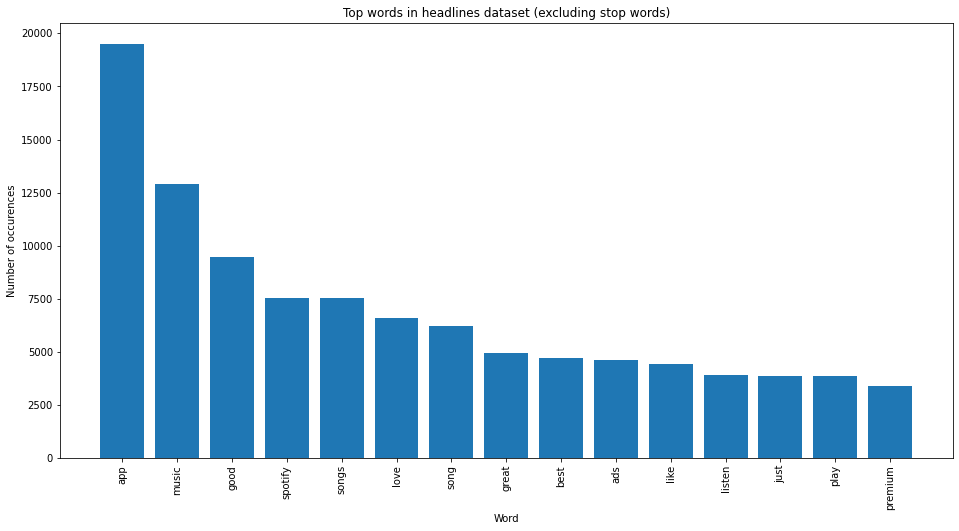

In [6]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [7]:
! python -m textblob.download_corpora


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [8]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]


In [9]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  795685
Mean number of words per headline:  13.261637693961566


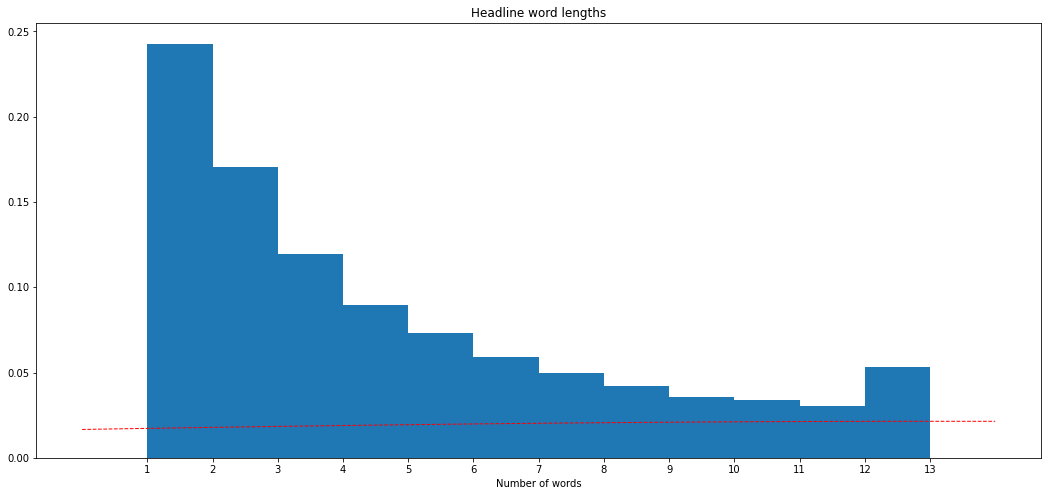

In [10]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

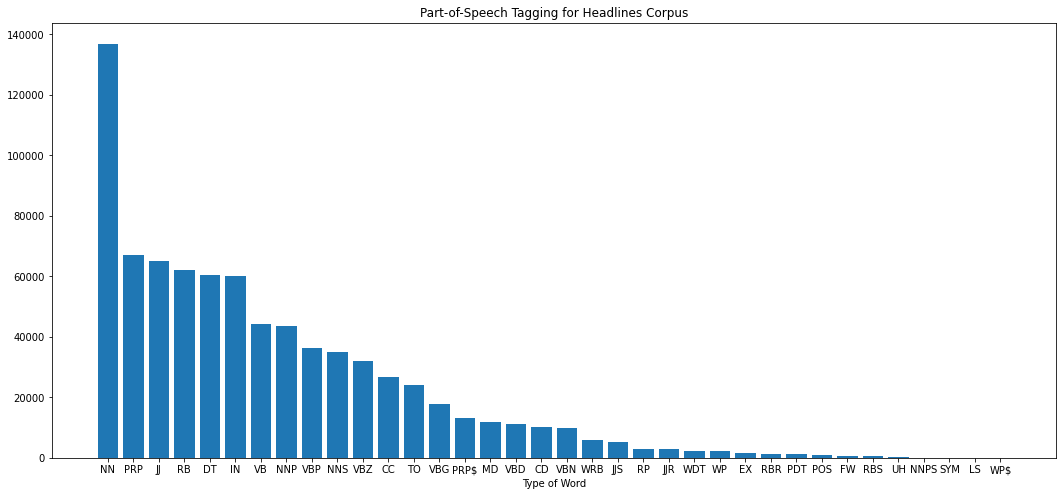

In [11]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

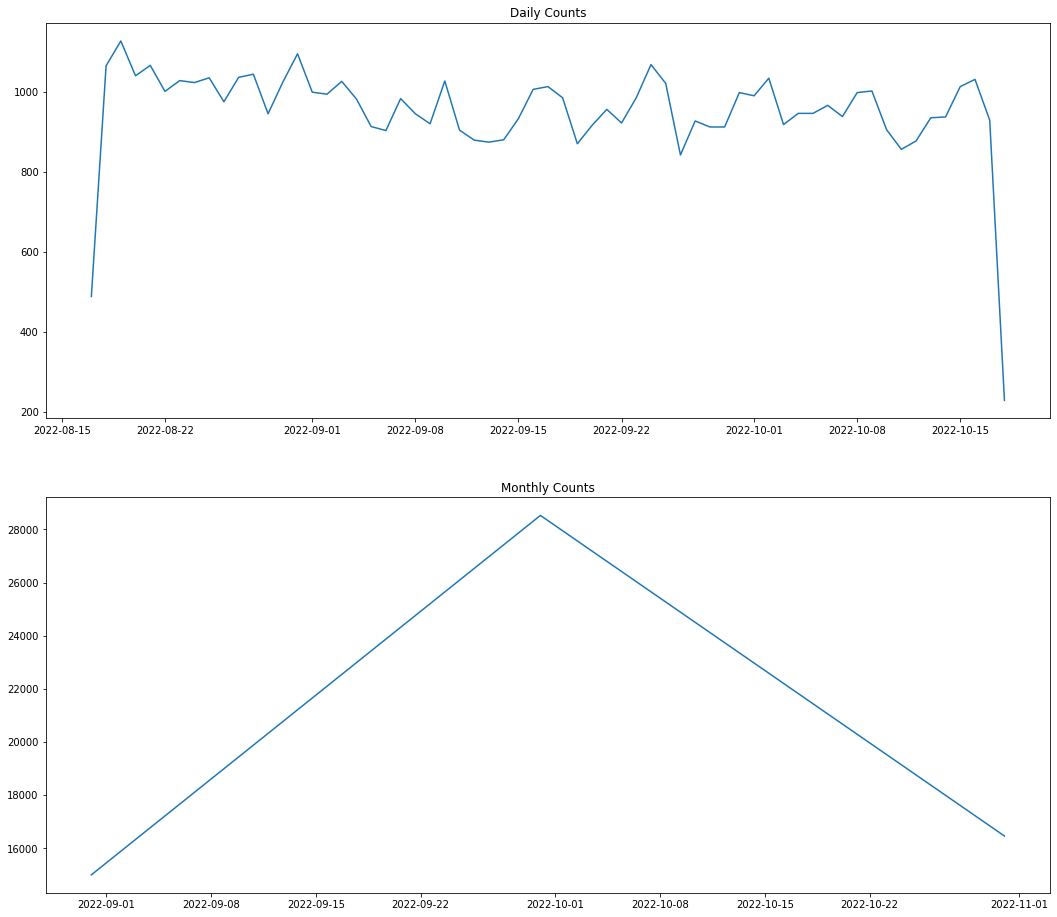

In [12]:
monthly_counts = reindexed_data.resample('M').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(2, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
plt.show()

In [13]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: Does not play like it use to cuts off every 3-5 seconds or not at all, getting to be like pandora.
Headline after vectorization: 
  (0, 5092)	1
  (0, 3926)	2
  (0, 5913)	1
  (0, 7080)	1
  (0, 2014)	1
  (0, 1696)	1
  (0, 2824)	1
  (0, 4894)	1


In [14]:
n_topics = 8


In [15]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [16]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [17]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [18]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [19]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  app music spotify best great love nice songs good song
Topic 2:  song songs play playlist just want listen spotify like shuffle
Topic 3:  music spotify love great best listen like listening play use
Topic 4:  good music quality ads songs spotify really premium like sound
Topic 5:  song play best music random aap dope mast free add
Topic 6:  songs superb playlist liked music great listen playlists play new
Topic 7:  ads premium ad songs free music 30 just app annoying
Topic 8:  love songs music just use song listen ads want listening


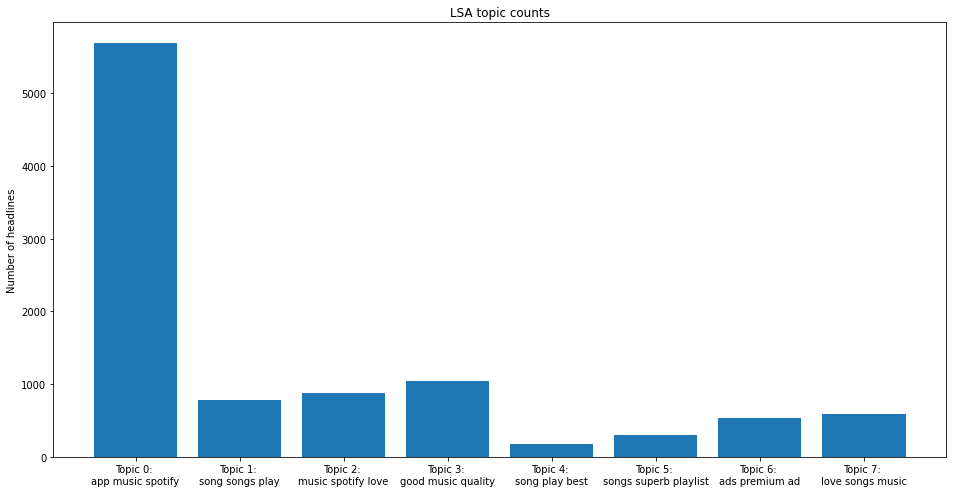

In [20]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()